This notebook is created using the following article: https://medium.com/analytics-vidhya/time-series-forecasting-a-complete-guide-d963142da33f

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from scipy.stats import variation

import sklearn
from sklearn.metrics import mean_squared_error

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [2]:
df_train = pd.read_csv(r'./data/train.csv')
display(df_train.head())
print(df_train.shape)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


(913000, 4)


In [3]:
df_test = pd.read_csv(r'./data/test.csv', usecols={'date', 'store', 'item'})
display(df_test.head())
print(df_test.shape)

,date,store,item
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1


(45000, 3)


# EDA

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


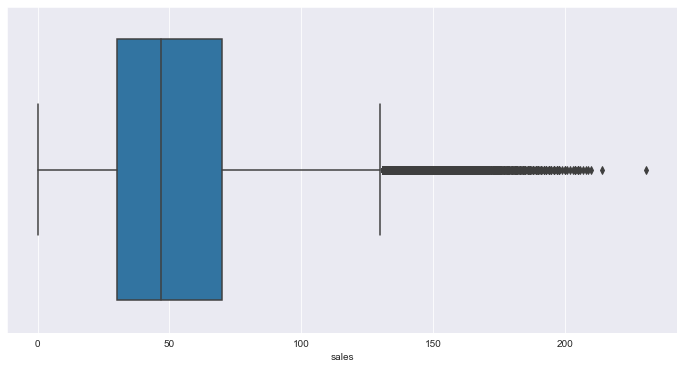

In [5]:
plt.figure(figsize=(12,6))
sns.boxplot(df_train['sales'])
plt.show()

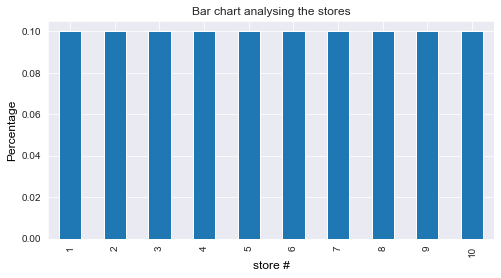

In [6]:
plt.figure(figsize= (8,4))
df_train["store"].value_counts(normalize=True).plot.bar()
plt.title("Bar chart analysing the stores",)
plt.xlabel("store #", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.ylabel("Percentage", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'} )
plt.show()

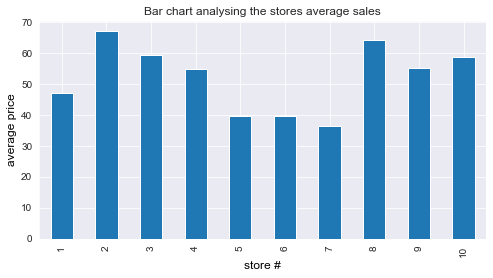

In [7]:
plt.figure(figsize= (8,4))
df_train.groupby(["store"])['sales'].mean().plot.bar()
plt.title("Bar chart analysing the stores average sales",)
plt.xlabel("store #", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.ylabel("average price", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'} )
plt.show()

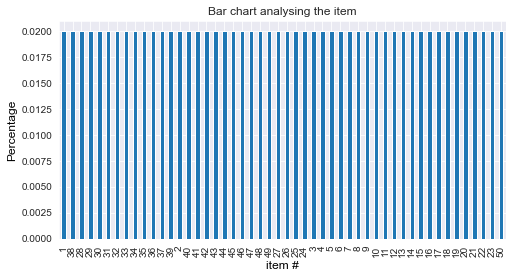

In [8]:
plt.figure(figsize= (8,4))
df_train["item"].value_counts(normalize=True).plot.bar()
plt.title("Bar chart analysing the item",)
plt.xlabel("item #", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.ylabel("Percentage", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'} )
plt.show()

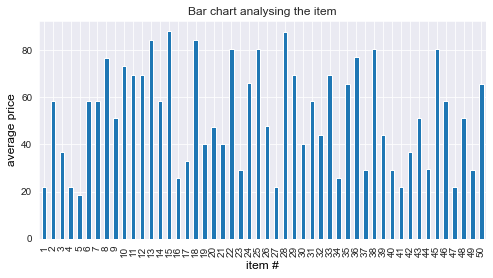

In [9]:
plt.figure(figsize= (8,4))
df_train.groupby(["item"])['sales'].mean().plot.bar()
plt.title("Bar chart analysing the item",)
plt.xlabel("item #", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'})
plt.ylabel("average price", fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Black'} )
plt.show()

In [10]:
# plt.figure(figsize=(15,8))
# sns.barplot(data=df_train, x='store', y= 'sales', hue='item')
# plt.title('Bar chart analysing Sales for different Store-Item\n', fontdict={'fontsize': 16})
# # plt.legend(loc = 'best')
# plt.show()

# Data Prep

In [12]:
df_train['store_item'] = df_train['store'].map(str)+'-'+df_train['item'].map(str)

In [13]:
df_train['date2'] = pd.to_datetime(df_train['date']).dt.to_period('d') 

In [14]:
df_train.head()

,date,store,item,sales,store_item,date2
0,2013-01-01,1,1,13,1-1,2013-01-01
1,2013-01-02,1,1,11,1-1,2013-01-02
2,2013-01-03,1,1,14,1-1,2013-01-03
3,2013-01-04,1,1,13,1-1,2013-01-04
4,2013-01-05,1,1,10,1-1,2013-01-05


In [15]:
data_2_34 = df_train[df_train['store_item'] == '2-34']
data_2_34.head()

,date,store,item,sales,store_item,date2
604406,2013-01-01,2,34,18,2-34,2013-01-01
604407,2013-01-02,2,34,20,2-34,2013-01-02
604408,2013-01-03,2,34,23,2-34,2013-01-03
604409,2013-01-04,2,34,14,2-34,2013-01-04
604410,2013-01-05,2,34,18,2-34,2013-01-05


In [16]:
data1 = data_2_34.groupby(['date2'])['sales'].sum()#.reset_index()
data1 = pd.DataFrame(data1)
data1.index = data1.index.to_timestamp()

In [17]:
data1.index.dtype

dtype('<M8[ns]')

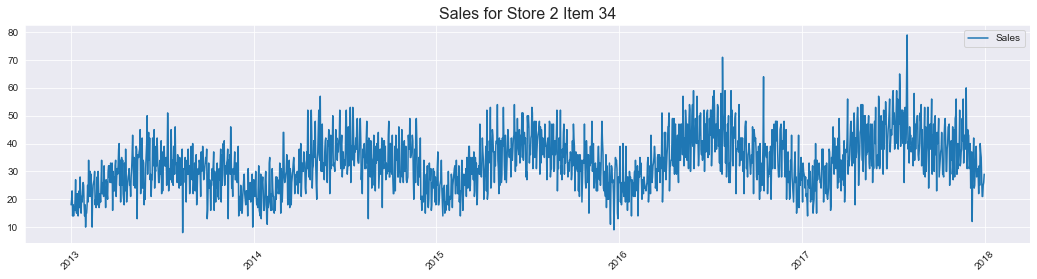

In [18]:
plt.figure(figsize=(18,4))
plt.plot(data1['sales'],label='Sales')
# plt.plot(data1[0 : train_len]['year_month'], data1[0 : train_len]['sales'],label='train')
# plt.plot(data1[train_len : ]['year_month'], data1[train_len : ]['sales'],label='test')
plt.legend(loc='best')
plt.title('Sales for Store 2 Item 34', fontdict={'fontsize': 16, 'fontweight' : 5, })
plt.xticks(rotation = 45,)
plt.show()

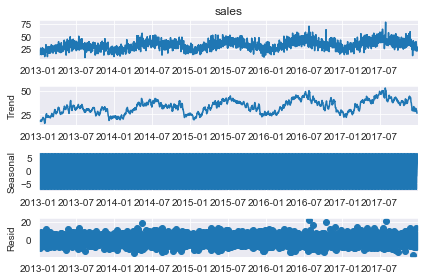

In [19]:
# from pylab import rcParams
import statsmodels.api as sm
# rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data1.sales, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

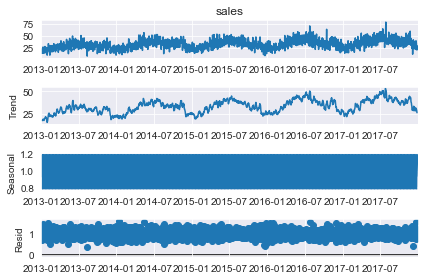

In [20]:
decomposition = sm.tsa.seasonal_decompose(data1.sales, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

This data is seasonal.

# Modeling

In [21]:
period=31

In [22]:
train_len = data1.shape[0]-period
train = data1[0 : train_len]
test = data1[train_len : ]

## Navie Method

In [23]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['sales'][train_len-1]

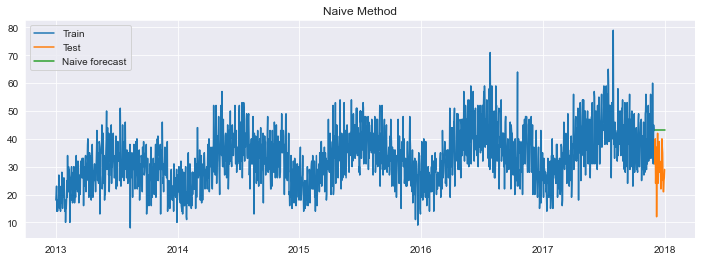

In [24]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

In [25]:
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_naive['naive_forecast'])/test['sales'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,14.66,53.09


## Simple Average Method

In [26]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['sales'].mean()

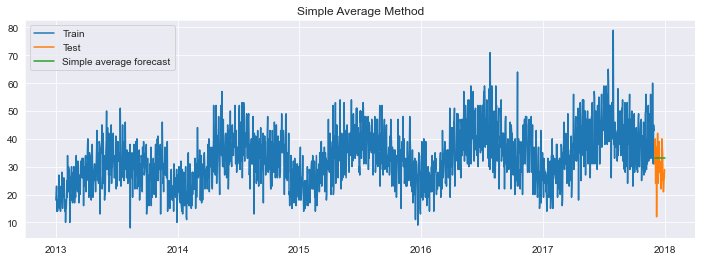

In [27]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple average forecast')
plt.legend(loc='best')
plt.title('Simple Average Method')
plt.show()

In [28]:
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_avg['avg_forecast'])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple average method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,14.66,53.09
0,Simple average method,7.39,25.22


## Simple moving average method

In [29]:
y_hat_sma = data1.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = data1['sales'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

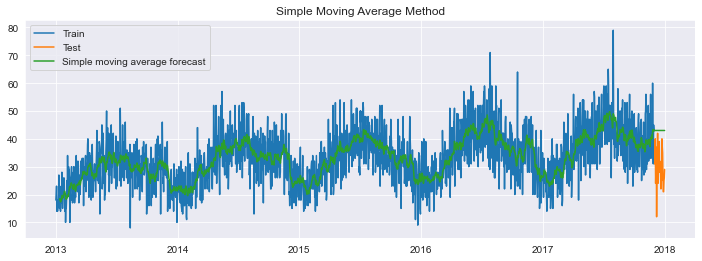

In [30]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [31]:
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_sma['sma_forecast'][train_len:])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,14.66,53.09
0,Simple average method,7.39,25.22
0,Simple moving average forecast,14.66,53.09


## Exponential Smoothing Techniques


In [33]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

### Holt Winters' additive method with trend and seasonality


In [34]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['sales']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.07998991112039952, 'smoothing_trend': 0.021313596414765233, 'smoothing_seasonal': 0.031984747595238464, 'damping_trend': nan, 'initial_level': 32.779340853630714, 'initial_trend': 0.10689782983522274, 'initial_seasons': array([-15.35982661, -14.66560087, -15.79655345, -16.5672053 ,
       -14.66456992, -15.62174605, -14.76595344, -15.61819234,
       -16.14728756, -15.56354001, -14.71677688, -14.97283206]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


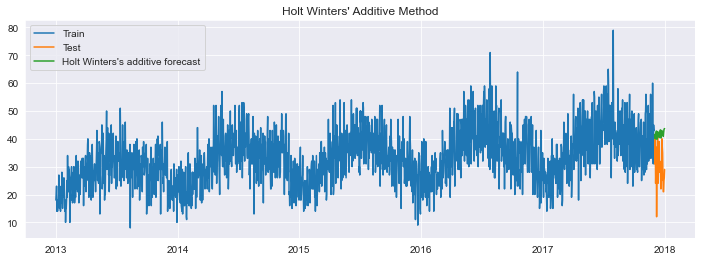

In [35]:
plt.figure(figsize=(12,4))
plt.plot( train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winters\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Additive Method')
plt.show()

In [36]:
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_hwa['hw_forecast'])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,14.66,53.09
0,Simple average method,7.39,25.22
0,Simple moving average forecast,14.66,53.09
0,Holt Winters' additive method,13.91,49.74


Note: The additive method has the most accuracy for this data.

### Holt Winter's multiplicative method with trend and seasonality


In [37]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['sales']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.08051452369673091, 'smoothing_trend': 0.021200969104474564, 'smoothing_seasonal': 0.03841602098093685, 'damping_trend': nan, 'initial_level': 18.373083100962084, 'initial_trend': 0.08405211595191944, 'initial_seasons': array([0.98732683, 1.03197667, 1.01559469, 0.92876762, 0.98095775,
       1.02645881, 1.04978469, 1.03350519, 1.02159148, 0.99199323,
       1.03798745, 0.98769768]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


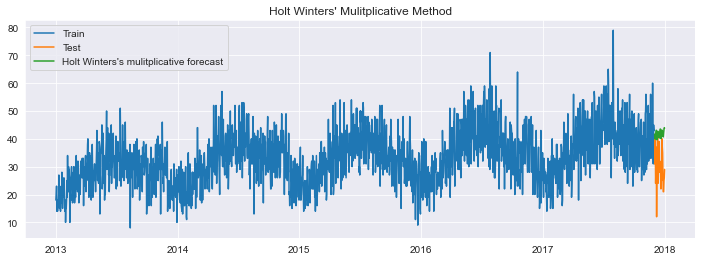

In [38]:
plt.figure(figsize=(12,4))
plt.plot( train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt Winters\'s mulitplicative forecast')
plt.legend(loc='best')
plt.title('Holt Winters\' Mulitplicative Method')
plt.show()

In [39]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_hwm['hw_forecast'])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,14.66,53.09
0,Simple average method,7.39,25.22
0,Simple moving average forecast,14.66,53.09
0,Holt Winters' additive method,13.91,49.74
0,Holt Winters' multiplicative method,13.92,49.77


Comment: The results are fairly similar for for the last two models when comparing the MAPE, but the RMSE has a stark difference. 

**For this data, the Multiplicative method is the the best to explain the trend and seasonality in the data.**

## Auto Regressive methods


### Check whether the time series is stationary

#### Augmented Dickey-Fuller (ADF) test

In [40]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(data1['sales'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' %adf_test[1])

ADF Statistic: -3.056764
Critical Values @ 0.05: -2.86
p-value: 0.029923


The data is not stationary given that p-value is greater than 0.05.

#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [41]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(data1['sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 2.093176
Critical Values @ 0.05: 0.46
p-value: 0.010000


C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The data is stationary given that p-value is greater than 0.05.

### Box Cox transformation to make variance constant

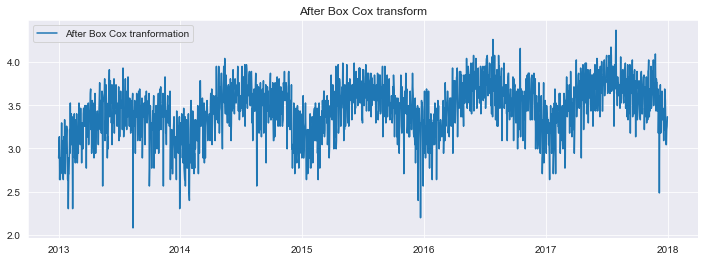

In [42]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data1['sales'], lmbda=0), index = data1.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

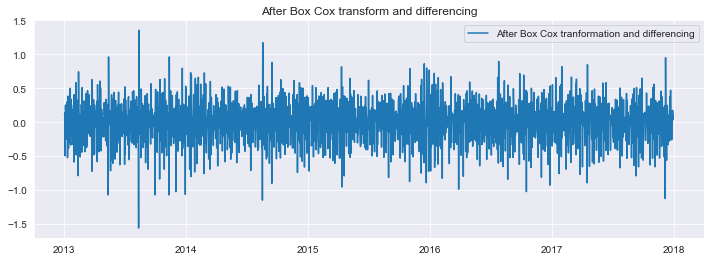

In [43]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data1.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [44]:
data_boxcox_diff.dropna(inplace=True)
data_boxcox_diff.tail()


date2
2017-12-27   -0.251314
2017-12-28    0.000000
2017-12-29    0.174353
2017-12-30    0.039221
2017-12-31    0.109199
Freq: D, dtype: float64

### Transformed Tests

#### Augmented Dickey-Fuller (ADF) test

In [45]:
adf_test = adfuller(data_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -11.880431
Critical Values @ 0.05: -2.86
p-value: 0.000000


#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [46]:
kpss_test = kpss(data_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.021534
Critical Values @ 0.05: 0.46
p-value: 0.100000


C:\Users\Utkarsh.Goyal\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### Train-Test Split

In [47]:
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

### Auto regression method (AR)


In [48]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const      0.000467
ar.L1.y   -0.458184
dtype: float64


In [49]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

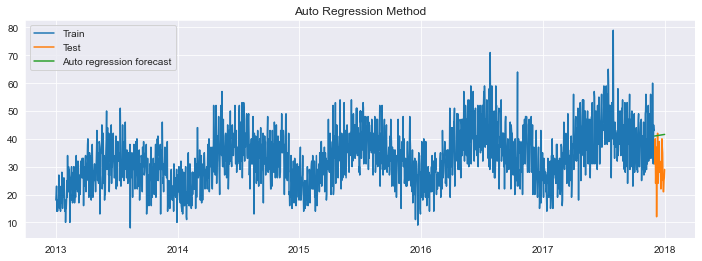

In [50]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto regression forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

In [51]:
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive (AR) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,14.66,53.09
0,Simple average method,7.39,25.22
0,Simple moving average forecast,14.66,53.09
0,Holt Winters' additive method,13.91,49.74
0,Holt Winters' multiplicative method,13.92,49.77
0,Autoregressive (AR) method,13.18,47.16


### Moving average method (MA)

In [52]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const      0.000453
ma.L1.y   -0.908723
dtype: float64


In [53]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

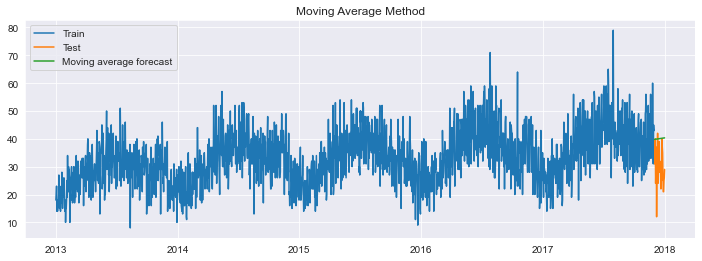

In [54]:
plt.figure(figsize=(12,4))
plt.plot(data1['sales'][:train_len], label='Train')
plt.plot(data1['sales'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

In [55]:
# Calculate RMSE and MAPE

rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_ma['ma_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_ma['ma_forecast'][test.index.min():])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Moving Average (MA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,14.66,53.09
0,Simple average method,7.39,25.22
0,Simple moving average forecast,14.66,53.09
0,Holt Winters' additive method,13.91,49.74
0,Holt Winters' multiplicative method,13.92,49.77
0,Autoregressive (AR) method,13.18,47.16
0,Moving Average (MA) method,12.14,43.02


### Auto regression moving average method (ARMA)

In [56]:
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const      0.000450
ar.L1.y    0.056242
ma.L1.y   -0.915537
dtype: float64


In [57]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

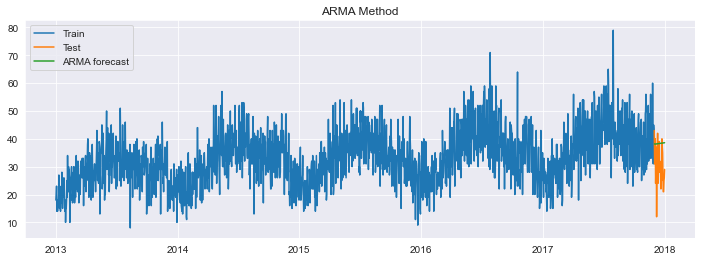

In [58]:
plt.figure(figsize=(12,4))
plt.plot( data1['sales'][:train_len-1], label='Train')
plt.plot(data1['sales'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA Method')
plt.show()

In [59]:
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_arma['arma_forecast'][train_len-1:])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_arma['arma_forecast'][train_len-1:])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,14.66,53.09
0,Simple average method,7.39,25.22
0,Simple moving average forecast,14.66,53.09
0,Holt Winters' additive method,13.91,49.74
0,Holt Winters' multiplicative method,13.92,49.77
0,Autoregressive (AR) method,13.18,47.16
0,Moving Average (MA) method,12.14,43.02
0,Autoregressive moving average (ARMA) method,10.74,37.76


### Auto regressive integrated moving average (ARIMA)


In [60]:
model = ARIMA(train_data_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

const        0.000450
ar.L1.D.y    0.056242
ma.L1.D.y   -0.915537
dtype: float64


In [61]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

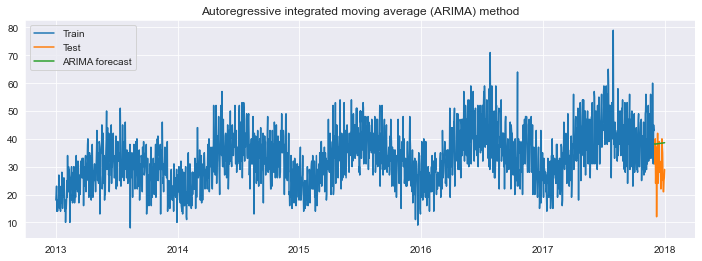

In [62]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

In [63]:
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_arima['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_arima['arima_forecast'][test.index.min():])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,14.66,53.09
0,Simple average method,7.39,25.22
0,Simple moving average forecast,14.66,53.09
0,Holt Winters' additive method,13.91,49.74
0,Holt Winters' multiplicative method,13.92,49.77
0,Autoregressive (AR) method,13.18,47.16
0,Moving Average (MA) method,12.14,43.02
0,Autoregressive moving average (ARMA) method,10.74,37.76
0,Autoregressive integrated moving average (ARIM...,10.74,37.76


### Seasonal auto regressive integrated moving average (SARIMA)

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1       0.053294
ma.L1      -0.913833
ar.S.L12   -0.010171
ma.S.L12   -0.999557
sigma2      0.058662
dtype: float64


In [65]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

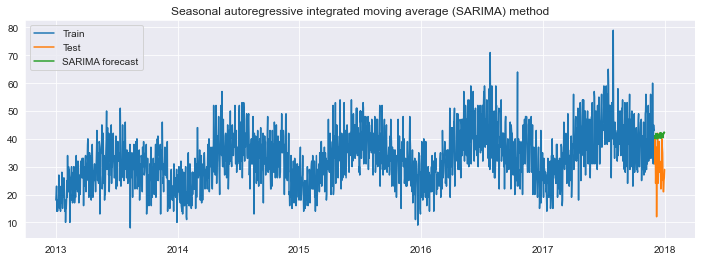

In [66]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [67]:
rmse = np.sqrt(mean_squared_error(test['sales'], y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,14.66,53.09
0,Simple average method,7.39,25.22
0,Simple moving average forecast,14.66,53.09
0,Holt Winters' additive method,13.91,49.74
0,Holt Winters' multiplicative method,13.92,49.77
0,Autoregressive (AR) method,13.18,47.16
0,Moving Average (MA) method,12.14,43.02
0,Autoregressive moving average (ARMA) method,10.74,37.76
0,Autoregressive integrated moving average (ARIM...,10.74,37.76
0,Seasonal autoregressive integrated moving aver...,13.29,47.38


# Conclusion

In [68]:
results.sort_values(['RMSE', 'MAPE'], ascending=False)[-3:]

,Method,RMSE,MAPE
0,Autoregressive moving average (ARMA) method,10.74,37.76
0,Autoregressive integrated moving average (ARIM...,10.74,37.76
0,Simple average method,7.39,25.22


**SARIMA model is the best one for this type of modeling given that it captured the trends in the data perfectly.**